In [38]:
import numpy as np
import scipy
import scipy.integrate
import scipy.linalg
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm


def tridiag_mult(M, x):
    # Multiply tridiagonal matrix by a vector
    j = np.multiply( M, x )
    
    res = j[1]
    res[:-1] += j[0,1:]
    res[1:] += j[-1,:-1]
    return res

def gen_mats ( m_m, m_s, mesh, c, d):
    
    n = mesh.size
    
    x_mid = (mesh[1:] + mesh[:-1]) / 2.0
    dx = mesh[1:] - mesh[:-1]
    c_x_mid = c(x_mid)
    d_x_mid = d(x_mid)
    
    
    M = np.zeros((3,n))
    S = np.zeros((3,n))

    m = np.asarray([
        [0, m_m[0,1]],
        [m_m[0,0],m_m[1,1]],
        [m_m[1,0],0]
    ])
    s = np.asarray([
        [0, m_s[0,1]],
        [m_s[0,0],m_s[1,1]],
        [m_s[1,0],0]
    ])

    for i in range(n-1):
        M[:,i:i+2] += m * c_x_mid[i] * dx[i]
        S[:,i:i+2] += s * d_x_mid[i] / dx[i]

    return M, S




def step_dU ( c, d, mesh, t, dt, U, boundaries, theta = 1, M=None, S=None ):
    '''Solve for time derivative of temperature samples that satisfy heat equation
    Uses theta method,
    Accomadates arbitrary neumann or dirichlet boundaries,
    '''
    
    # Assemble our utility matrix
    Q = (M / dt) + (theta * S)
    
    # Solve for our new step size
    R = -1 * tridiag_mult(S, U)
    
    if M is None or S is None:
        M, S = gen_mats(
            m_m = np.asarray([
                [1/3,1/6],
                [1/6,1/3]
            ]),
            m_s = np.asarray([
                [1,-1],
                [-1,1]
            ]),
            mesh = mesh,
            c = c,
            d = d
        )
    
    for i, b in zip((0,-1), boundaries):
        # Set the delta numerically, so that dU + U is known (=f(t)) for t+dt
        if b.get('type') == 'dirichlet':
            Q[1, -1] = 1
            Q[2,-2] = 0
            R[i] = b.get('f')(t) - U[i]
            
        # Just add in the flux on the particular side
        elif b.get('type') == 'neumann':
            R[i] += b.get('f')(t)

    
    dU = scipy.linalg.solve_banded(
        (1,1),
        Q, R,
        overwrite_ab = True,
        overwrite_b = True
    )

    return dU
    



def heat_solve( U0, mesh, t0, t1, dt, dim_fn, boundaries = (None, None), theta=1, progress=True):
    '''
    '''
    boundaries = list(map(
        lambda x: {'type': 'neumann', 'f': lambda t: 0.0} if x is None else x,
        boundaries
    ))
    
    temp = [U0]
    ts  = np.arange(t0, t1+dt, dt)
    
    loop = ts[1:]
    M, S = gen_mats(
        m_m = np.asarray([
            [1/3,1/6],
            [1/6,1/3]
        ]),
        m_s = np.asarray([
            [1,-1],
            [-1,1]
        ]),
        mesh = mesh,
        c = dim_fn,
        d = dim_fn,
    )
    
    # Loop across static time samples
    for t in (tqdm(loop) if progress else loop):

        # Load current temperature
        U = temp[-1]
        
        # Solve for global time derivative that satisfies
        dU = step_dU(
            c = dim_fn,
            d = dim_fn,
            mesh = mesh,
            t = t,
            dt = dt,
            U = U,
            theta = theta*1.0,
            boundaries = boundaries,
            M = M,
            S = S,
        )

        # Store the new temperature back
        temp.append(U + dU)

        
    res = {
        'temp': np.asarray(temp),
        'time': ts
    }
    return res

In [39]:
dims = np.arange(3)
ns = [
    (10, 1/20),
    (20,1/80),
    (40, 1/320)
]


sols = []
for p in dims:
    s = []
    for n, dt in ns:
        sol = heat_solve(
            U0 = np.zeros(n),
            mesh = np.linspace(0, 1, n),
            t0 = 0, t1 = 2, dt = dt,
            dim_fn = lambda x: x**p,
            boundaries = (
                {'type': 'neumann', 'f': lambda t: 0.0},
                {'type': 'dirichlet', 'f': lambda t: 1.0},
            ),
            theta=1,
            progress=False
        )
        s.append(sol)
    sols.append(s)

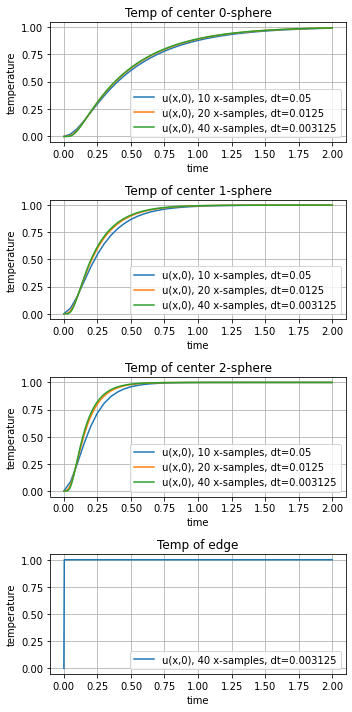

In [40]:
fig, axs = plt.subplots( 4, 1, figsize=(5,10) )
# print(axs.shape)

axs = axs.flatten()

for p in dims:
    for i,n in enumerate(ns):
        sol = sols[p][i]
        axs[p].plot(
            sol['time'],
            sol['temp'][:,0],
            label='u(x,0), {0} x-samples, dt={1}'.format( n[0], n[1] )
        )        
    axs[p].set_xlabel('time')
    axs[p].set_ylabel('temperature')
    axs[p].set_title( 'Temp of center {0}-sphere'.format( p ) )
    axs[p].legend()
    axs[p].grid()
    

# Plot the last boundary plot
axs[-1].plot(
    sols[0][-1]['time'],
    sols[0][-1]['temp'][:,-1],
    label='u(x,0), {0} x-samples, dt={1}'.format( n[0], n[1] )
)
axs[-1].set_xlabel('time')
axs[-1].set_ylabel('temperature')
axs[-1].set_title( 'Temp of edge' )
axs[-1].legend()
axs[-1].grid()


plt.tight_layout()
plt.show()
